In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Flatten, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load('en_core_web_lg')

df = pd.read_csv('TrainingDS.csv')
df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
df.head()

,ID,Text,Class
0,1,Trump supporters needed to say the 4 Democrats...,0
1,2,Send them back!!Why the hell are they even her...,1
2,3,Yeah...Im wondering if send them back works fo...,1
3,4,I know you realize you cant pretend that you d...,1
4,5,"Donny, you owe all people an apology for appla...",0


In [3]:
X_train, y_train = df['Text'], df['Class']

In [4]:
maxlen = 50
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [5]:
tokenizer.fit_on_texts(X_train)

In [6]:
sequences = tokenizer.texts_to_sequences(X_train)

In [7]:
index = 0
print(X_train[index])
print(sequences[index])

Trump supporters needed to say the 4 Democrats socialist Squad are racist towards Trump America supporter. America has freedom of speech and it was a Trump hyper rally not a Socialist Democratic squad rally. The rally said send her back the one not migrants Socialist Democratic
[11, 95, 1228, 2, 77, 1, 197, 174, 384, 198, 19, 25, 979, 11, 107, 980, 107, 67, 718, 9, 385, 6, 16, 33, 8, 11, 2499, 36, 20, 8, 384, 447, 198, 36, 1, 36, 72, 4, 5, 3, 1, 82, 20, 1229, 384, 447]


In [8]:
X_train = pad_sequences(sequences, maxlen=maxlen)

In [9]:
X_train[:2]

array([[   0,    0,    0,    0,   11,   95, 1228,    2,   77,    1,  197,
         174,  384,  198,   19,   25,  979,   11,  107,  980,  107,   67,
         718,    9,  385,    6,   16,   33,    8,   11, 2499,   36,   20,
           8,  384,  447,  198,   36,    1,   36,   72,    4,    5,    3,
           1,   82,   20, 1229,  384,  447],
       [   7,    3,  100,    1,  301,   19,   21,  130,   89,  238,  640,
           9,  485,   16,   31,   40,    1, 1230,   63,    6,    1, 1230,
         360,  207,  531,    1,   17,  641,   22,  342,  323,    8,  324,
         302, 2500,   74,  343,  303,  642, 2501,   64,   11,    6,  117,
          94,  344,    1,  129,    6, 2502]])

In [106]:
model = Sequential()
model.add(Embedding(num_words, 100, input_length=maxlen))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))

In [107]:
model.compile(optimizer='nadam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [108]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [109]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=5,
                    validation_split=0.15,
                    callbacks=[checkpoint_callback])

Epoch 1/5
40/40 [==============================] - 7s 91ms/step - loss: 0.6295 - accuracy: 0.6463 - auc: 0.6531 - val_loss: 0.7771 - val_accuracy: 0.6533 - val_auc: 0.8143

Epoch 00001: val_accuracy improved from -inf to 0.65333, saving model to best_model.h5
Epoch 2/5
40/40 [==============================] - 3s 74ms/step - loss: 0.5020 - accuracy: 0.7725 - auc: 0.8305 - val_loss: 0.5262 - val_accuracy: 0.7733 - val_auc: 0.8307

Epoch 00002: val_accuracy improved from 0.65333 to 0.77333, saving model to best_model.h5
Epoch 3/5
40/40 [==============================] - 3s 72ms/step - loss: 0.3724 - accuracy: 0.8596 - auc: 0.9107 - val_loss: 0.5122 - val_accuracy: 0.7556 - val_auc: 0.8408

Epoch 00003: val_accuracy did not improve from 0.77333
Epoch 4/5
40/40 [==============================] - 3s 72ms/step - loss: 0.2796 - accuracy: 0.8925 - auc: 0.9593 - val_loss: 0.4748 - val_accuracy: 0.7822 - val_auc: 0.8675

Epoch 00004: val_accuracy improved from 0.77333 to 0.78222, saving model to 

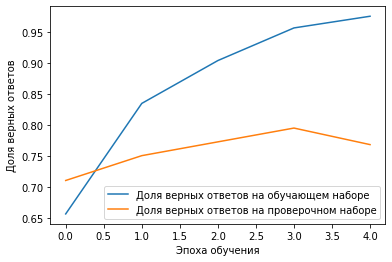

In [105]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [63]:
test_sequences = tokenizer.texts_to_sequences(df_test['Text'])

In [64]:
X_test = pad_sequences(test_sequences, maxlen=maxlen)
y_test = df_test['Class']

In [65]:
model.load_weights(model_save_path)
test_predict = model.predict(X_test)
test_predict = np.where(test_predict >= 0.5,1,0)

In [66]:
df_test['Class'] = test_predict
df_test.head()

,ID,Text,Class
0,1,Ye bhi illegal immigrant lag rahi hai -- NRC r...,1
1,2,Yeah I asked someone about her skirt today and...,0
2,3,You need to clean your SELECTIVE HEARING COBWE...,0
3,4,It easy to complain and criticize with no offe...,1
4,5,Guess the send-them-back policy of your friend...,1


In [67]:
df_test.drop('Text', axis=1).to_csv('test_lstm.csv', index=False, sep=',')

Kaggle ~0.8